In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cufflinks as cf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

cf.set_config_file(offline=True)

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

## 数据读取

In [2]:
path = r"D:\新建文件夹 (2)\WeChat Files\wxid_r5nb2w32sc5q12\FileStorage\File\2021-05\双十一淘宝美妆数据.csv"

In [3]:
data = pd.read_csv(path, index_col=0, parse_dates=True)

In [4]:
data = data.loc['2016-11-14'].copy()
data.reset_index(drop=True, inplace=True)

In [5]:
data.columns = ['id', '标题', '价格', '销量', '评论数', '品牌']

In [6]:
data.head()

,id,标题,价格,销量,评论数,品牌
0,A18164178225,CHANDO/自然堂 雪域精粹纯粹滋润霜50g 补水保湿 滋润水润面霜,139.0,26719.0,2704.0,自然堂
1,A18177105952,CHANDO/自然堂凝时鲜颜肌活乳液120ML 淡化细纹补水滋润专柜正品,194.0,8122.0,1492.0,自然堂
2,A18177226992,CHANDO/自然堂活泉保湿修护精华水（滋润型135ml 补水控油爽肤水,99.0,12668.0,589.0,自然堂
3,A18178033846,CHANDO/自然堂 男士劲爽控油洁面膏 100g 深层清洁 男士洗面奶,38.0,25805.0,4287.0,自然堂
4,A18178045259,CHANDO/自然堂雪域精粹纯粹滋润霜（清爽型）50g补水保湿滋润霜,139.0,5196.0,618.0,自然堂


## 数据清洗与预处理

In [7]:
data.isnull().sum()  # 检查缺失

id       0
标题       0
价格       0
销量     155
评论数    155
品牌       0
dtype: int64

In [8]:
data.dropna(inplace=True) # 去除包含缺失值的记录

In [9]:
data.duplicated().sum()  # 检查重复

1

In [10]:
data.drop_duplicates(inplace=True) # 去除重复记录

In [11]:
data = pd.get_dummies(data, columns=['品牌']) # 对品牌进行独热编码转换

In [12]:
# 新增关键词特征
data['功效_补水保湿'] = data['标题'].str.contains('补水|保湿').astype(int)
data['功效_淡化细纹'] = data['标题'].str.contains('淡化细纹').astype(int)
data['功效_美白'] = data['标题'].str.contains('美白').astype(int)
data['功效_控油'] = data['标题'].str.contains('控油').astype(int)
data['功效_清洁'] = data['标题'].str.contains('清洁').astype(int)
data['功效_去角质'] = data['标题'].str.contains('去角质').astype(int)
data['功效_防晒'] = data['标题'].str.contains('防晒').astype(int)

In [13]:
data.head()

,id,标题,价格,销量,评论数,品牌_佰草集,品牌_倩碧,品牌_兰芝,品牌_兰蔻,品牌_妮维雅,...,品牌_雅漾,品牌_雅诗兰黛,品牌_雪花秀,功效_补水保湿,功效_淡化细纹,功效_美白,功效_控油,功效_清洁,功效_去角质,功效_防晒
0,A18164178225,CHANDO/自然堂 雪域精粹纯粹滋润霜50g 补水保湿 滋润水润面霜,139.0,26719.0,2704.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,A18177105952,CHANDO/自然堂凝时鲜颜肌活乳液120ML 淡化细纹补水滋润专柜正品,194.0,8122.0,1492.0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,A18177226992,CHANDO/自然堂活泉保湿修护精华水（滋润型135ml 补水控油爽肤水,99.0,12668.0,589.0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,A18178033846,CHANDO/自然堂 男士劲爽控油洁面膏 100g 深层清洁 男士洗面奶,38.0,25805.0,4287.0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,A18178045259,CHANDO/自然堂雪域精粹纯粹滋润霜（清爽型）50g补水保湿滋润霜,139.0,5196.0,618.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## 皮尔逊积相关系数矩阵探索销量印象因素

In [14]:
correlation_matrix = data[data.columns[2:]].corr() # 计算相关系数矩阵

<AxesSubplot:>

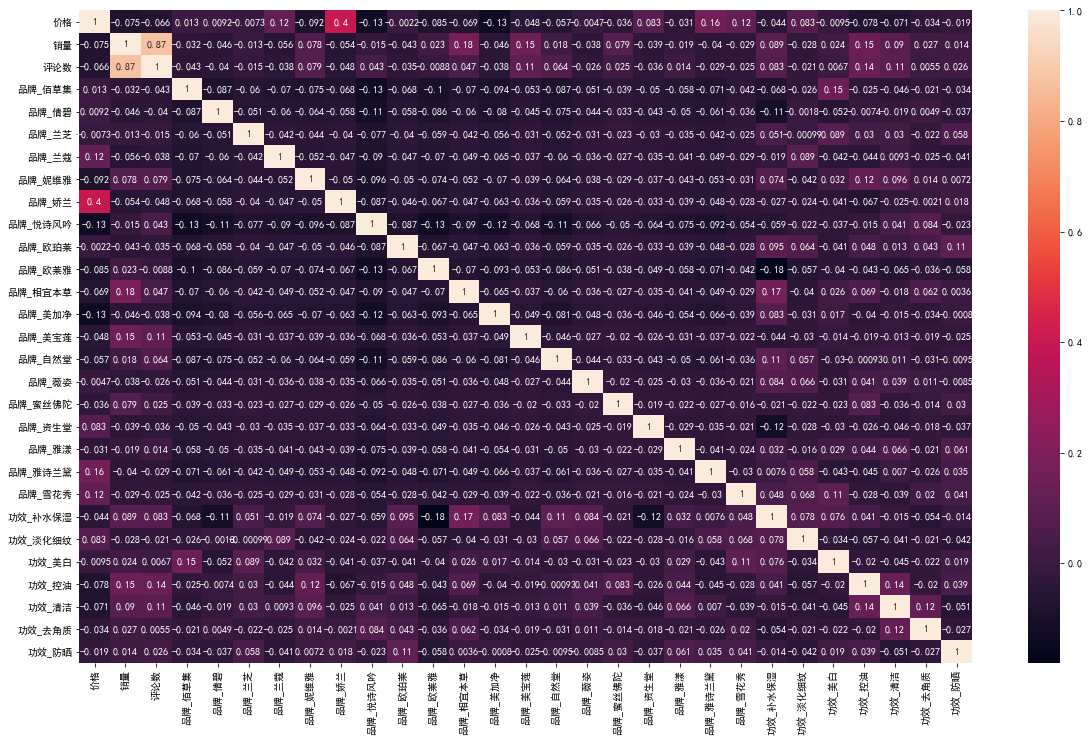

In [15]:
plt.figure(figsize=[20,12])
sns.heatmap(correlation_matrix, annot=True)

In [16]:
correlation_matrix['销量'].sort_values(ascending=False)

销量         1.000000
评论数        0.871575
品牌_相宜本草    0.179413
品牌_美宝莲     0.148902
功效_控油      0.146151
功效_清洁      0.090240
功效_补水保湿    0.088556
品牌_蜜丝佛陀    0.078938
品牌_妮维雅     0.077759
功效_去角质     0.026911
功效_美白      0.024146
品牌_欧莱雅     0.023092
品牌_自然堂     0.018028
功效_防晒      0.013718
品牌_兰芝     -0.012835
品牌_悦诗风吟   -0.014955
品牌_雅漾     -0.018706
功效_淡化细纹   -0.027912
品牌_雪花秀    -0.028626
品牌_佰草集    -0.032075
品牌_薇姿     -0.037906
品牌_资生堂    -0.038889
品牌_雅诗兰黛   -0.039583
品牌_欧珀莱    -0.043042
品牌_倩碧     -0.045959
品牌_美加净    -0.046079
品牌_娇兰     -0.053552
品牌_兰蔻     -0.055785
价格        -0.074753
Name: 销量, dtype: float64

In [17]:
correlation_matrix['销量'].sort_values(ascending=False).iloc[1:].iplot(kind='bar', xTitle='影响因素',
                                                                        yTitle='与销量的相关性', title='销量影响因素条形图')

相关系数，又称皮尔逊积相关系数，是用来度量两个数量变量之间线性相关关系强度的数字。相关系数的范围是-1~+1。当相关系数接近于-1或+1时，表示强的线性关系，而相关系数越接近于0，线性关系也越弱。一般地，如果数据集中所有点都在一条斜率为正的直线上，则样本相关系数的值为+1  

+1 ：x和y之间存在一个完全线性关系  
-1 ：x和y之间存在一个完全负线性关系  

从上图可以发现，“评论数”、“品牌_相宜本草”、“品牌_美宝莲”、“功效_控油”、“功效_清洁”等几个特征与销量的正相关性最高，即评论数越多的产品销量越高、品牌是相宜本草、美宝莲则产品销量就更高、如果功能是控油、清洁则产品的销量就比较高。  

而“价格”、“品牌_兰蔻”、“品牌_娇兰”等几个特征与销量的相关性为负数，即价格最高，销量越低，如果品牌为兰蔻、娇兰则产品销量不佳，而兰蔻、娇兰的产品都属于单价比较高的，所以其实与价格越高，销量越低同理。

## 随机森林建模探索化妆品销量影响因素

In [18]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data.drop(['销量', 'id', '标题'], axis=1), data['销量'].values, test_size=0.2, random_state=28)

In [19]:
rfr = RandomForestRegressor() # 初始化随机森林模型

In [20]:
parameters = {'max_depth': np.arange(1, 20, 10),
              'min_samples_leaf': np.arange(1, 20, 5),
              'n_estimators': np.arange(10, 50, 10)
              }

In [21]:
rfr.fit(X_train, y_train) # 训练随机森林模型

RandomForestRegressor()

In [22]:
gs = GridSearchCV(rfr, parameters, cv=5)  # 网格搜索
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([ 1, 11]),
                         'min_samples_leaf': array([ 1,  6, 11, 16]),
                         'n_estimators': array([10, 20, 30, 40])})

In [23]:
y_pred = gs.best_estimator_.predict(X_test)

In [24]:
forest_mse = mean_squared_error(y_test, y_pred)
forest_rmse = np.sqrt(forest_mse)

In [25]:
forest_rmse  # 随机森林模型rmse

85463.52080575017

In [26]:
fig = data['销量'].iplot(kind='hist', bins=500, asFigure=True, title='销量分布')
fig.update_layout(xaxis_range=[0, 400000])

In [27]:
feature_importances = pd.Series(dict(zip(list(X_train), gs.best_estimator_.feature_importances_))).sort_values(ascending=False)

In [28]:
feature_importances.sort_values()

品牌_资生堂     5.566141e-10
品牌_娇兰      8.482878e-09
品牌_雪花秀     2.349881e-05
品牌_欧珀莱     5.048591e-05
品牌_薇姿      7.692656e-05
功效_淡化细纹    1.220761e-04
品牌_雅诗兰黛    2.380386e-04
品牌_倩碧      2.409930e-04
品牌_兰芝      8.225828e-04
品牌_美加净     8.447233e-04
品牌_兰蔻      8.720829e-04
品牌_雅漾      1.153868e-03
品牌_悦诗风吟    1.334888e-03
品牌_妮维雅     2.445000e-03
品牌_佰草集     2.670978e-03
功效_防晒      3.143769e-03
功效_美白      3.178172e-03
功效_清洁      4.831158e-03
品牌_自然堂     7.101148e-03
品牌_美宝莲     1.030589e-02
功效_控油      1.074851e-02
品牌_欧莱雅     1.200588e-02
功效_去角质     1.733891e-02
功效_补水保湿    2.080380e-02
品牌_蜜丝佛陀    3.299408e-02
品牌_相宜本草    4.685935e-02
价格         8.538835e-02
评论数        7.344048e-01
dtype: float64

In [29]:
feature_importances.sort_values().tail(10).iplot(kind='bar', orientation='h', title='随机森林模型得出的feature importance')

从上图可知， 对销量影响最大的两个因素为价格和评论数， 与上一部分的结论不谋而合。